# <center> Crop Yeild Prediction</center>

## 1. Setup

### 1.1 Checking Dependencies
Installing and importing required libraries

In [227]:
# cheking module installations 

%pip install pandas numpy seaborn matplotlib
%pip install scikit-learn  
%pip install statsmodels 
%pip install plotly 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 1.2 Importing Modules

In [228]:
# importing important modules

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl

from sklearn.model_selection import train_test_split
import math 
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import plotly.express as px
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score


### 1.4 Global Parameters

In [229]:
#TODO: change path to correct dataset directory
yield_dataset_path = "../../dataset/raw/Crop-yield-dataset/crop_yeild_prediction.csv"
target_filed = ""
RANDOM=12140860

### 1.3 Methods Defination

In [230]:
def readOriginalData():
    trainData = pd.read_csv(yield_dataset_path) 
    trainData["Item"] = trainData["Item"].replace("Sorghum","Jowar") 
    trainData["Item"] = trainData["Item"].replace("Rice, paddy","Rice") 
    trainData["Item"] = trainData["Item"].replace("Plantains and others","Mango") 
    # testData = pd.read_csv(test_data_link)

    return trainData

In [231]:
def seperateData(data,randomNumber=RANDOM):
    trainData , testData = train_test_split(data, test_size=0.2, shuffle=True,random_state=randomNumber)

    trainData.reset_index(inplace=True,drop=True)
    testData.reset_index(inplace=True,drop=True)

    return trainData, testData

In [232]:
def testFeature(data,featureName,compareFeature,target):
    corrMatrix = data.corr()

    sortData = corrMatrix[target].sort_values(ascending=True)
    # print(sortData)
    print(featureName, " corelation ==>",sortData[featureName])
    print(compareFeature," corelation ==>",sortData[compareFeature])

    figure, axis = plt.subplots(nrows=2,ncols=2,figsize=(8,4*2))
    axis = axis.flatten()
    oldKdePlot = sns.scatterplot(data,x=compareFeature,y=target,ax=axis[0])
    newKdePlot = sns.scatterplot(data,x=featureName,y=target,ax=axis[1])
    oldBoxPlot = sns.boxplot(data,y=compareFeature,ax=axis[2])
    newBoxPlot = sns.boxplot(data,y=featureName,ax=axis[3])
    plt.tight_layout()

In [233]:
def outlierRange(data, quan1=0.25, quan3=0.75):
    firstQuantile = data.quantile(quan1)
    thirdQuantile = data.quantile(quan3)

    IQR = thirdQuantile - firstQuantile 

    upperBound = firstQuantile + 1.5 * IQR
    lowerBound = thirdQuantile - 1.5 * IQR 
    return lowerBound, upperBound

In [234]:
def plotGraph(data,cols,target, plot="box"):
    nrows = math.ceil(len(cols)/3)
    figure, axis = plt.subplots(nrows=nrows,ncols=3,figsize=(12,4*nrows))
    axis = axis.flatten()
    for i in range(len(cols)):
        if(plot=="box"):
            boxPlot = sns.boxplot(data,y=cols[i],ax=axis[i])
        elif(plot=="scatter"):
            scatterPlot = sns.scatterplot(data,x=cols[i],y=target,ax=axis[i])
        elif (plot=="violin"):
            violinPlot = sns.violinplot(data,y=cols[i],ax=axis[i])
        else:
            kdePlot = sns.kdeplot(data,x=cols[i],ax=axis[i])
    plt.tight_layout()

In [235]:
def countOutlier(data,colName):
    lower_limit, upper_limit = outlierRange(data[colName])
    condition = (data[colName] < lower_limit) | (data[colName] > upper_limit)
    changedData = data[condition]
    print("outliers in ",colName," ==> ",changedData.shape[0])

In [236]:
def bestFitCoeffMatrix(matrix_A,matrix_b):
    matrix_A = np.column_stack((np.ones(matrix_A.shape[0]), matrix_A))

    psedoInv_A = np.dot(matrix_A.transpose(),matrix_A)
    psedoInv_A = np.linalg.inv(psedoInv_A)
    psedoInv_A = np.dot(psedoInv_A,matrix_A.transpose())

    bestX = np.dot(psedoInv_A, matrix_b)
    return bestX

In [237]:
def predictValue(matrix_A,matrix_x):
    matrix_A = np.column_stack((np.ones(matrix_A.shape[0]), matrix_A))
    matrix_p = np.matmul(matrix_A,matrix_x)
    
    return matrix_p

In [238]:
def gradientDescent(data, learningRate, iterations, target):

    data_A = data.drop(target, axis=1)


    object= StandardScaler()
    scale = object.fit_transform(data_A) 
    data_A = pd.DataFrame(scale,columns=data_A.columns)

    # Add a column of ones to X for the bias term
    data_A = np.column_stack((np.ones(data_A.shape[0]), data_A)) #620,16

    data_b = data[target]
    data_n = data_b.shape[0]

    # Initialize theta (model parameters)
    totalFeatures = data_A.shape[1]
    data_x = np.random.randn(totalFeatures, 1)#16,1
    data_b = np.array(data_b)
    data_b = data_b.reshape((data_b.shape[0],1))

    errorHistory = []
    validationHistory = []

    for i in range(iterations):
        # Calculate predictions
        predictions = np.matmul(data_A,data_x)

        # Calculate the error
        error = predictions - data_b

        # Calculate the gradient
        gradient =   (2/data_n) * np.matmul(data_A.T,error)

        # Update data_x 
        data_x = data_x - learningRate* gradient

        # Calculate and record the loss (Mean Squared Error)
        MSE = mean_squared_error(data_b,predictions)

        # print(MSE)
        errorHistory.append(MSE)
        # validationHistory.append(np.mean((data_A.dot(data_x)-predictions)**2))
        # Convergence Criterion: Stop when the change in loss is small
        if iterations > 0 and i>2:
            validationHistory.append(errorHistory[-1]-errorHistory[-2])
            if (abs(errorHistory[-1] - errorHistory[-2]) < 0.000000001):
                print("BREAK....")
                break

    return data_x, errorHistory,validationHistory

## 2. Datasets

### 2.1 Loading datasets

**Reading Complete Data**

In [239]:
yield_data = readOriginalData() 

**Splitting Dataset into train and test**

In [240]:
train_data, test_data = seperateData(yield_data)

### 2.2 Data Analyzing

In [241]:
#checking first five entries

yield_data.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,Rice,1990,23333,1485.0,121.0,16.37
3,3,Albania,Jowar,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [242]:
yield_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


The `yield_data` DataFrame has 28,242 entries (rows) and 8 columns. Summary of each column:

1. **Unnamed: 0 (int64):** An integer column with non-null values, representing an unnamed index or identifier for each entry.

2. **Area (object):** A categorical column with non-null values, representing the area associated with crop.

3. **Item (object):** A categorical column with non-null values, representing the item or crop associated with the data entry.

4. **Year (int64):** An integer column with non-null values, representing the year associated with the data entry.

5. **hg/ha_yield (int64):** An integer column with non-null values, likely representing the yield measured in hectograms per hectare.

6. **average_rain_fall_mm_per_year (float64):** A floating-point column with non-null values, representing the average rainfall in millimeters per year.

7. **pesticides_tonnes (float64):** A floating-point column with non-null values, representing the amount of pesticides used in tonnes.

8. **avg_temp (float64):** A floating-point column with non-null values, representing the average temperature.

In [243]:
yield_data.shape

(28242, 8)

The yield_data DataFrame has a shape of (28242, 8), indicating it has 28,242 rows and 8 columns.

**Checking test and train dataset**

In [244]:
test_data.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,7237,Dominican Republic,Maize,1999,12633,1410.0,5398.00,26.62
1,13425,India,Jowar,2007,8443,1083.0,27422.77,27.31
2,18401,Malawi,Rice,2012,18453,1181.0,775.83,20.42
3,19262,Mexico,Rice,1994,42555,758.0,34468.93,21.46
4,7411,Dominican Republic,Cassava,2011,78686,1410.0,6316.61,26.66


In [245]:
test_data.shape

(5649, 8)

Our test data contains 20 percent of whole data which is randomly taken from data. 

In [246]:
train_data.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,19965,Mexico,Rice,2006,47857,758.0,50891.95,17.23
1,10549,India,Potatoes,1990,157136,1083.0,75000.00,24.10
2,15787,Italy,Potatoes,1996,224667,832.0,74617.20,12.28
3,16091,Jamaica,Yams,1999,163770,2051.0,909.71,27.12
4,10957,India,Jowar,1992,9820,1083.0,70791.00,25.58


In [247]:
train_data.shape

(22593, 8)

Our train data contains 80 percent or whole data. We are seperating yeild_data by randomly using random seed.

### 2.3 Data Preprocessing

**Removing unwanted columns**

In [248]:
yield_data.drop('Unnamed: 0', axis=1, inplace=True)

In the code cell above, the 'Unnamed: 0' column is dropped from the yield_data DataFrame.
This column is an unnamed index or identifier and is removed using the drop method.
This column is not needed for our training dataset or our model.

**Removing null values**

In [249]:
yield_data.isnull().sum()

Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

As we can see their is no null value here. So need to handle null values

**Handling Duplicate Values**

In [250]:
yield_data.duplicated().sum()

2310

As we can see their is 2310 duplicate values which we need to handle, to get proper result for our yield prediction model 

**Removing duplicate values**

In [251]:
yield_data.drop_duplicates(inplace=True)

In [252]:
yield_data.duplicated().sum()

0

Now our dataset not contains any duplicate values

**Handling average_rain_fall_mm_per_year values**

In [253]:
def is_string(value):
    try:
        float(value)
        return False
    except:
        return True

**Overview**:

This function identifies the row indices in the 'yield_data' DataFrame where the entries in the 'average_rain_fall_mm_per_year' column are non-numeric strings. The flagged rows could be candidates for removal or subjected to additional processing based on the particular requirements of the task.

In [254]:
dropped_yield_data = yield_data[yield_data['average_rain_fall_mm_per_year'].apply(is_string)].index

In [255]:
yield_data = yield_data.drop(dropped_yield_data)

In [256]:
yield_data

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,Albania,Rice,1990,23333,1485.0,121.00,16.37
3,Albania,Jowar,1990,12500,1485.0,121.00,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,Zimbabwe,Rice,2013,22581,657.0,2550.07,19.76
28238,Zimbabwe,Jowar,2013,3066,657.0,2550.07,19.76
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [257]:
yield_data['average_rain_fall_mm_per_year'] = yield_data['average_rain_fall_mm_per_year'].astype(
    np.float64)

 The 'average_rain_fall_mm_per_year' column in the yield_data DataFrame is converted to the float64 data type. 
    This conversion ensures that the values in this column are treated as numerical floating-point numbers, 
    facilitating numeric operations and analysis.

### 2.4 Data Visualization

**Graph Frequency vs Area**

In [258]:
column_ranges = yield_data.describe(include='all').loc[['min', 'max']]
print(column_ranges)

    Area Item    Year  hg/ha_yield  average_rain_fall_mm_per_year  \
min  NaN  NaN  1990.0         50.0                           51.0   
max  NaN  NaN  2013.0     501412.0                         3240.0   

     pesticides_tonnes  avg_temp  
min               0.04      1.30  
max          367778.00     30.65  


In [259]:
len(yield_data['Area'].unique())

101

The code generates a countplot for the 'Area' column in the yield_data DataFrame. 
It visualizes the frequency distribution of unique areas present in the dataset. 
The figure size is set to (15, 20) for better visibility.

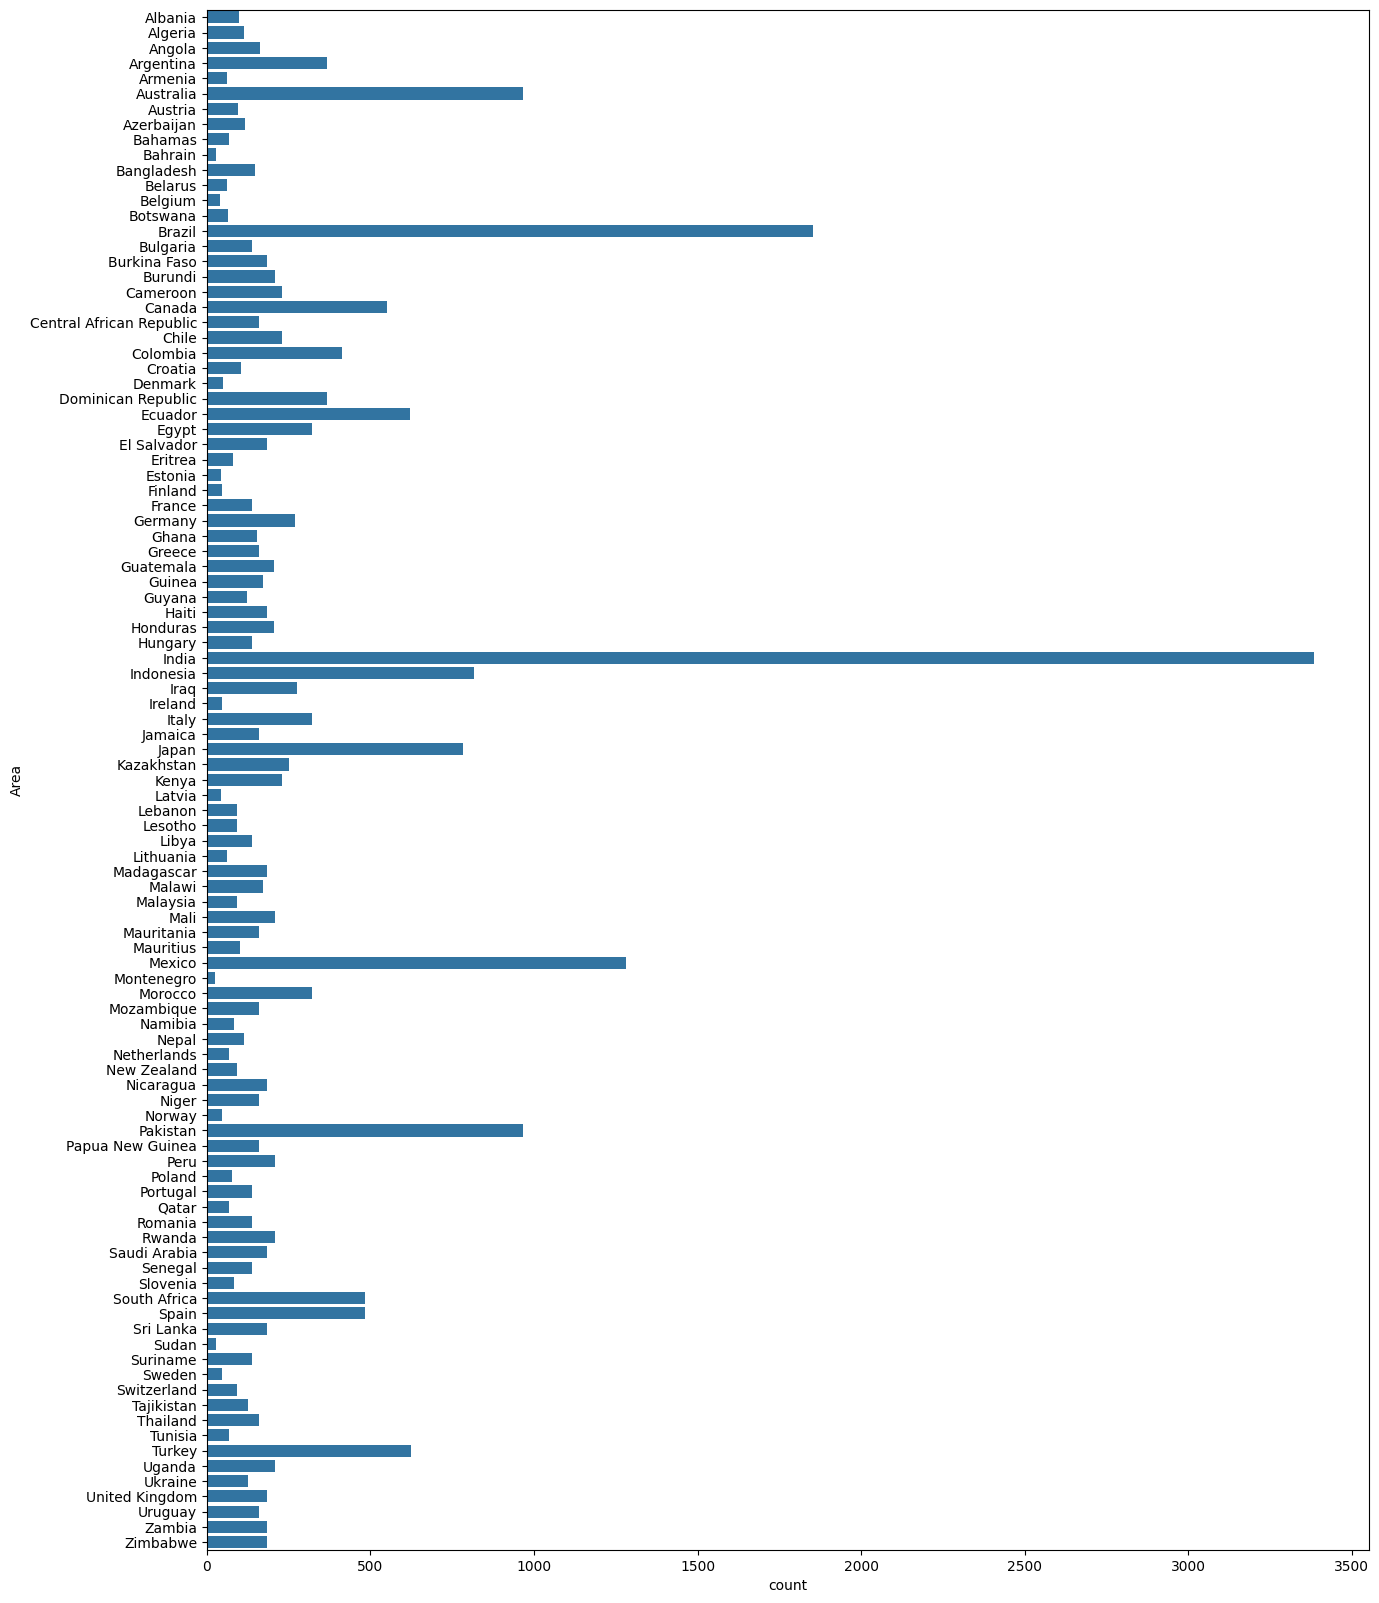

In [260]:
plt.figure(figsize=(15, 20))
sns.countplot(y=yield_data['Area'])
plt.show()

In [261]:
(yield_data['Area'].value_counts() < 500).sum()

91

**Crop Yield Per Country**

In [262]:
country_name = yield_data['Area'].unique()
country_yield = []
for state in country_name:
    country_yield.append(yield_data[yield_data['Area'] == state]['hg/ha_yield'].sum())

In [263]:
yield_data['hg/ha_yield'].sum()

1996196943

In [264]:
country_yield

[5711536,
 6711464,
 5722563,
 32864032,
 4524100,
 109111062,
 10852258,
 4608380,
 4384717,
 4443889,
 7720159,
 4704812,
 8442270,
 470651,
 136340329,
 6263075,
 6083337,
 7031146,
 10717883,
 34706922,
 4255627,
 20561214,
 26927138,
 6083167,
 10701651,
 25312166,
 21315591,
 36828848,
 16855944,
 1452416,
 3595638,
 6210668,
 15790618,
 38780463,
 9260371,
 14571925,
 16508723,
 7975743,
 8361103,
 8619194,
 10920131,
 8824110,
 274219558,
 68067328,
 10984722,
 9104030,
 32280700,
 19698007,
 100924145,
 9965212,
 14391737,
 3698588,
 6956804,
 4258932,
 9016288,
 4174348,
 6103523,
 8346715,
 7934982,
 15106720,
 4465841,
 12684212,
 113698872,
 1645100,
 22173010,
 6964027,
 3165475,
 4113713,
 14086433,
 17657728,
 12819227,
 12316327,
 6721305,
 49264956,
 10729929,
 15201910,
 6564711,
 12154347,
 5995626,
 6006156,
 7741053,
 15171886,
 10342677,
 7197013,
 30999849,
 46773540,
 11217741,
 1896346,
 14786468,
 8620653,
 13336346,
 6295210,
 9511720,
 3724246,
 52263950,
 

**Yield Per Country Graph**

/tmp/ipykernel_10148/115656886.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=country_name, x=country_yield, palette=colors)


<Axes: >

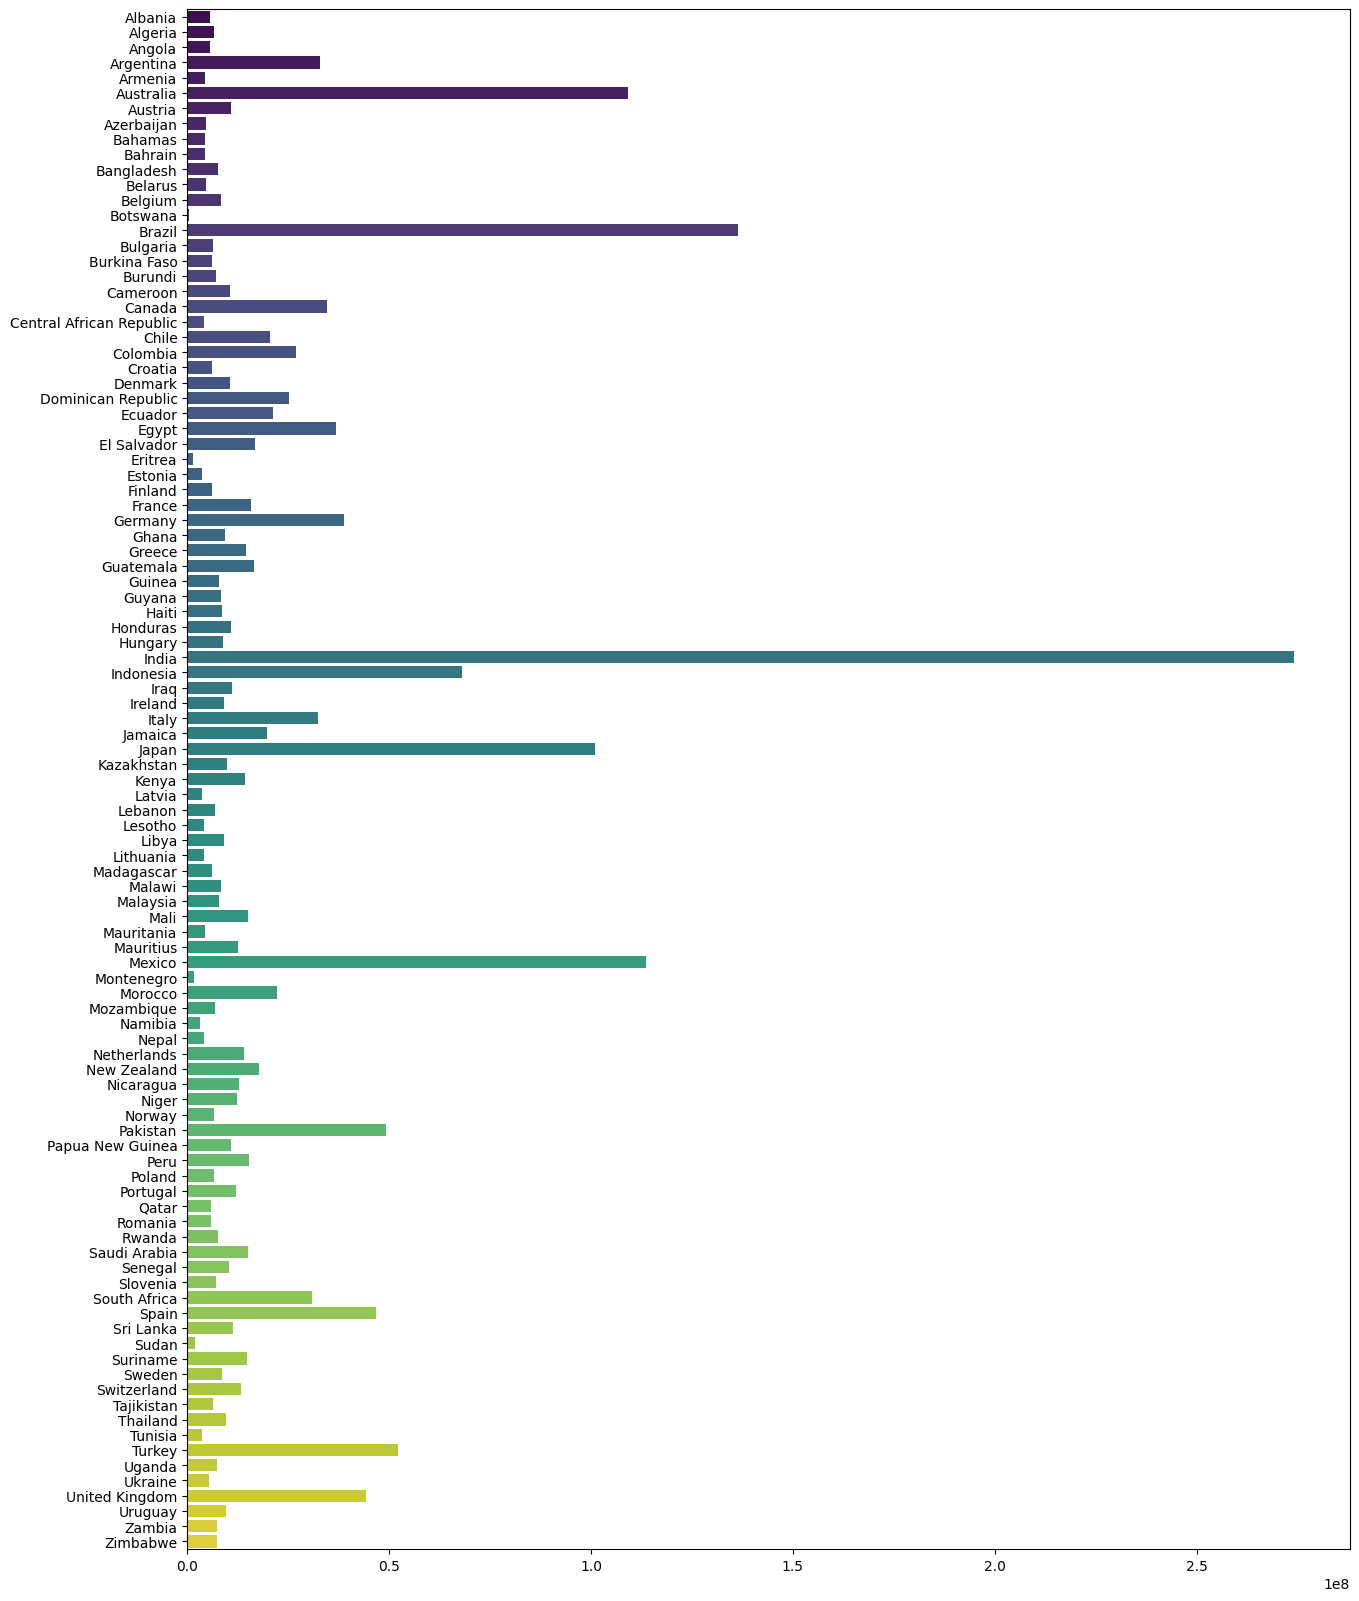

In [265]:
# Define colors for bars
colors = sns.color_palette("viridis", len(country_name))
plt.figure(figsize=(15, 20))
sns.barplot(y=country_name, x=country_yield, palette=colors)

**Crop frequency**

<Axes: xlabel='count', ylabel='Item'>

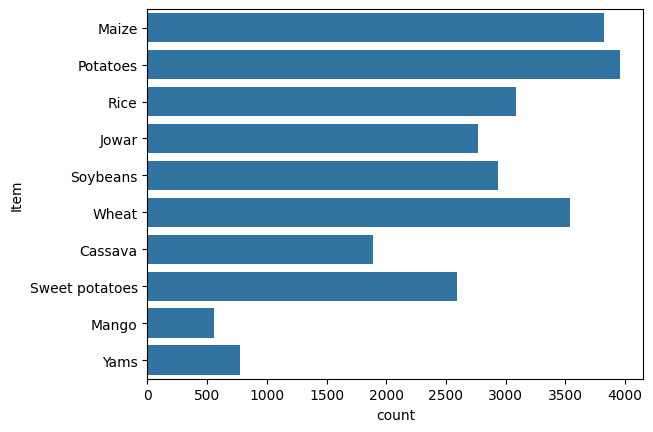

In [266]:
sns.countplot(y=yield_data['Item'])

**Crop wise yield**

In [267]:
crop_name = yield_data['Item'].unique()
crop_yield = []
for crop in crop_name:
    crop_yield.append(yield_data[yield_data['Item'] == crop]['hg/ha_yield'].sum())

In [268]:
print(crop_name)

['Maize' 'Potatoes' 'Rice' 'Jowar' 'Soybeans' 'Wheat' 'Cassava'
 'Sweet potatoes' 'Mango' 'Yams']


<Axes: >

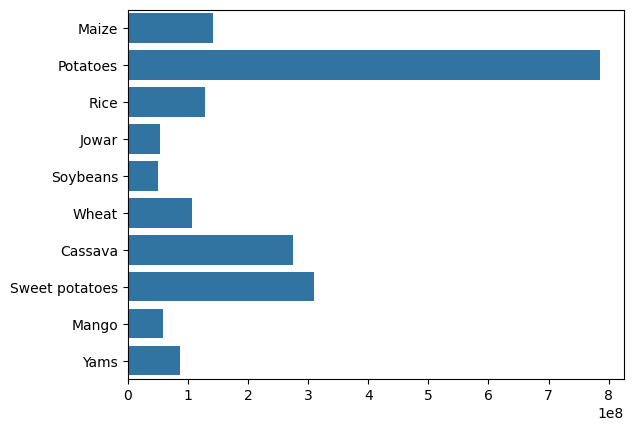

In [269]:
sns.barplot(y=crop_name, x=crop_yield)

## 3. Model Training

**Splitting datasets**

In [270]:
col = ['Year', 'average_rain_fall_mm_per_year',
       'pesticides_tonnes', 'avg_temp', 'Area', 'Item', 'hg/ha_yield']
yield_data = yield_data[col]
X = yield_data.iloc[:, :-1]
y = yield_data.iloc[:, -1]

In [271]:
yield_data.head(3)

,Year,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Area,Item,hg/ha_yield
0,1990,1485.0,121.0,16.37,Albania,Maize,36613
1,1990,1485.0,121.0,16.37,Albania,Potatoes,66667
2,1990,1485.0,121.0,16.37,Albania,Rice,23333


In [272]:
# Splitting dataset using train_and_test function

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=0, shuffle=True)

**Converting Categorical to Numerical and Scaling the values**

In [273]:
encoder = OneHotEncoder(drop='first')
scaler = StandardScaler()

preprocesser = ColumnTransformer(
    transformers=[
        ('StandardScale', scaler, [0, 1, 2, 3]),
        ('OHE', encoder, [4, 5]),
    ],
    remainder='passthrough'
)

In [274]:
X_train_dummy = preprocesser.fit_transform(X_train)
X_test_dummy = preprocesser.transform(X_test)

In [275]:
preprocesser.get_feature_names_out(col[:-1])

array(['StandardScale__Year',
       'StandardScale__average_rain_fall_mm_per_year',
       'StandardScale__pesticides_tonnes', 'StandardScale__avg_temp',
       'OHE__Area_Algeria', 'OHE__Area_Angola', 'OHE__Area_Argentina',
       'OHE__Area_Armenia', 'OHE__Area_Australia', 'OHE__Area_Austria',
       'OHE__Area_Azerbaijan', 'OHE__Area_Bahamas', 'OHE__Area_Bahrain',
       'OHE__Area_Bangladesh', 'OHE__Area_Belarus', 'OHE__Area_Belgium',
       'OHE__Area_Botswana', 'OHE__Area_Brazil', 'OHE__Area_Bulgaria',
       'OHE__Area_Burkina Faso', 'OHE__Area_Burundi',
       'OHE__Area_Cameroon', 'OHE__Area_Canada',
       'OHE__Area_Central African Republic', 'OHE__Area_Chile',
       'OHE__Area_Colombia', 'OHE__Area_Croatia', 'OHE__Area_Denmark',
       'OHE__Area_Dominican Republic', 'OHE__Area_Ecuador',
       'OHE__Area_Egypt', 'OHE__Area_El Salvador', 'OHE__Area_Eritrea',
       'OHE__Area_Estonia', 'OHE__Area_Finland', 'OHE__Area_France',
       'OHE__Area_Germany', 'OHE__Area_Ghana',

**Training our model**

In [283]:

models_list = {
    'linearRegression_Model': LinearRegression(),
    'lassoRegression_Model': Lasso(),
    'RidgeRegression_Model': Ridge(),
    'DecistionTree_Regressor': DecisionTreeRegressor(random_state=RANDOM)
}

for model_name, model in models_list.items():
    model.fit(X_train_dummy, y_train)
    y_prediction = model.predict(X_test_dummy)

    print(f"{model_name} \n: Mae : {mean_absolute_error(y_test,y_prediction)} score : {r2_score(y_test,y_prediction)}")

linearRegression_Model 
: Mae : 29907.4701490508 score : 0.7473128868225185


/home/karan/Templates/Crop-Recommendation-system/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67301658128.35547, tolerance: 14848622817.505228
  model = cd_fast.sparse_enet_coordinate_descent(


lassoRegression_Model 
: Mae : 29893.99761210708 score : 0.7473261758122396
RidgeRegression_Model 
: Mae : 29863.747389258424 score : 0.747306181644466
DecistionTree_Regressor 
: Mae : 3940.8829766724502 score : 0.9791914980511048


**Training Hyperparams**

In [ ]:
models_list = {
    'DecistionTree_Regressor': DecisionTreeRegressor(random_state=RANDOM)
}

for i in range(5,15):
    models_list[]

for model_name, model in models_list.items():
    model.fit(X_train_dummy, y_train)
    y_prediction = model.predict(X_test_dummy)

    print(f"{model_name} \n: Mae : {mean_absolute_error(y_test,y_prediction)} score : {r2_score(y_test,y_prediction)}")

**Model selection**

In [281]:
Final_Model = DecisionTreeRegressor(min_samples_split=5,max_depth=10)
Final_Model.fit(X_train_dummy, y_train)
Final_Model.predict(X_test_dummy)

array([ 48754.77142857,  18343.62670565,  10123.65798923, ...,
        21328.31207675,  26284.76457883, 103241.52598622])

## 4. Prediction

In [278]:
def prediction(Year, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp, Area, Item):
    # Create an array of the input features
    features = np.array([[Year, average_rain_fall_mm_per_year,
                        pesticides_tonnes, avg_temp, Area, Item]], dtype=object)

    # Transform the features using the preprocessor
    transformed_features = preprocesser.transform(features)

    # Make the prediction
    predicted_yield = Final_Model.predict(transformed_features).reshape(1, -1)

    return predicted_yield[0]


Year = 1990
average_rain_fall_mm_per_year = 1485.0
pesticides_tonnes = 121.00
avg_temp = 16.37
Area = 'India'
Item = 'Maize'
output = prediction(Year, average_rain_fall_mm_per_year,
                    pesticides_tonnes, avg_temp, Area, Item)


/home/karan/Templates/Crop-Recommendation-system/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/karan/Templates/Crop-Recommendation-system/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [279]:
print(output)

[36613.]


In [280]:
with open('Crop_Yield_Prediction.pkl', 'wb') as model_file:
    pkl.dump(Final_Model, model_file)

pkl.dump(preprocesser,open('preprocessor.pkl','wb'))